<a href="https://colab.research.google.com/github/AprendizajeProfundo2021/trabajo-equipo7/blob/main/Detecci%C3%B3n/FasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Librerías

In [2]:
%%capture
!pip install icevision[all]==0.5.1
!pip install torchtext==0.8.1

In [ ]:
import os
os.kill(os.getpid(), 9)

In [1]:
from fastai.vision.all import *

In [2]:
from icevision.all import *

In [3]:
%%capture
!wget https://www.dropbox.com/s/pgy5ps3clel2p4b/celldataset.zip?dl=1 -O celldataset.zip
!unzip celldataset.zip

In [4]:
%%capture
!wget https://www.dropbox.com/s/w5pvuzvqwonkqf4/FasterRCNN_celldetection.pth

### 1. Parser

In [5]:
class AnotacionParser(parsers.Parser, parsers.FilepathMixin, parsers.LabelsMixin, parsers.BBoxesMixin):
    pass

In [6]:
AnotacionParser.generate_template()

def __iter__(self) -> Any:
def imageid(self, o) -> Hashable:
def image_width_height(self, o) -> Tuple[int, int]:
    return get_image_size(self.filepath(o))
def filepath(self, o) -> Union[str, Path]:
def bboxes(self, o) -> List[BBox]:
def labels(self, o) -> List[int]:


In [7]:
import os
import re

In [8]:
class AnotacionParser(parsers.Parser, parsers.FilepathMixin, parsers.LabelsMixin, parsers.BBoxesMixin):
    def __init__(self, path_img,path_anotaciones):
        self.path_img = path_img
        self.path_anotaciones= path_anotaciones

    def __iter__(self):
      with os.scandir(self.path_anotaciones) as ficheros:
        for fichero in ficheros:
          yield fichero.name

    def imageid(self, o) -> Hashable: #o --> nombre de la anotación
      return o[:o.find('.')]

    def filepath(self, o) -> Union[str, Path]:
      path=Path(f"{o[:o.find('.')]}.jpg")
      return self.path_img / path

    def image_width_height(self, o) -> Tuple[int, int]:
      return get_image_size(self.path_img+'/'+f"{o[:o.find('.')]}.jpg")

    def labels(self, o) -> List[int]:
      path=self.path_anotaciones+'/'+o
      anotacion=json.loads(open(path).read())
      label=[]
      for j in anotacion:
        label.append(1)
      return label

    def bboxes(self, o) -> List[BBox]:
      path=self.path_anotaciones+'/'+o
      anotacion=json.loads(open(path).read())
      bbox=[]
      for j in anotacion:
        bbox.append(BBox.from_xyxy(j['bbox'][0],j['bbox'][1],j['bbox'][2],j['bbox'][3]))
      return bbox

In [9]:
class_map=ClassMap(['cell'])

In [10]:
path=Path('/content/celldataset')
path_train_img=path/'train'/'images'
path_train_anot=path/'train'/'annotations'
path_test_img=path/'test'/'images'
path_test_anot=path/'test'/'annotations'

In [11]:
parser = AnotacionParser(str(path_train_img), str(path_train_anot))

In [12]:
parser_test = AnotacionParser(str(path_test_img), str(path_test_anot))

### 2. Records

In [13]:
train_records, valid_records= parser.parse(RandomSplitter((0.8, 0.2)))

0it [00:00, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:126
AUTOFIX-START - ️🔨  Autofixing record with imageid: 27  ️🔨 | icevision.core.record:_pre_replay:88
AUTOFIX-FAIL - Cannot auto-fix coordinates: <BBox (xmin:5, ymin:814, xmax:159, ymax:434)>
	y_min:814 is greater than or equal to y_max:434 | icevision.core.record_mixins:_autofix:155
AUTOFIX-REPORT - Removed annotation with index: 14, for more info check the AUTOFIX-FAIL messages above | icevision.core.record:autofix:40


In [28]:
test_records,_=parser_test.parse(RandomSplitter((1, 0)))

0it [00:00, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:126


### 3. Transforms

The transforms and augmentations are an important part in the construction of the computer visions' models. IceVision includes a library [Albumentations](https://github.com/albumentations-team/albumentations) which provide us a different transformations.

We won't be using any flipping or rotating transformation because of the nature of our dataset. It doesn't make sense to flip or rotate a form, so we'll just normalize the images.


In [15]:
presize = 1000
size = 800

In [16]:
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize,shift_scale_rotate=None,crop_fn=None, horizontal_flip=None, pad=None), tfms.A.Normalize()])

### 4. Dataset

The `Dataset` class is used to combine the records and the tranformations. We will create a dataset for our training set, validation set and testing test.


In [29]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)
test_ds = Dataset(test_records, valid_tfms) 

Once we have created all the datasets we can show the images that take part in these datasets. This will help us to visualize and check the transformations we made to the original images.


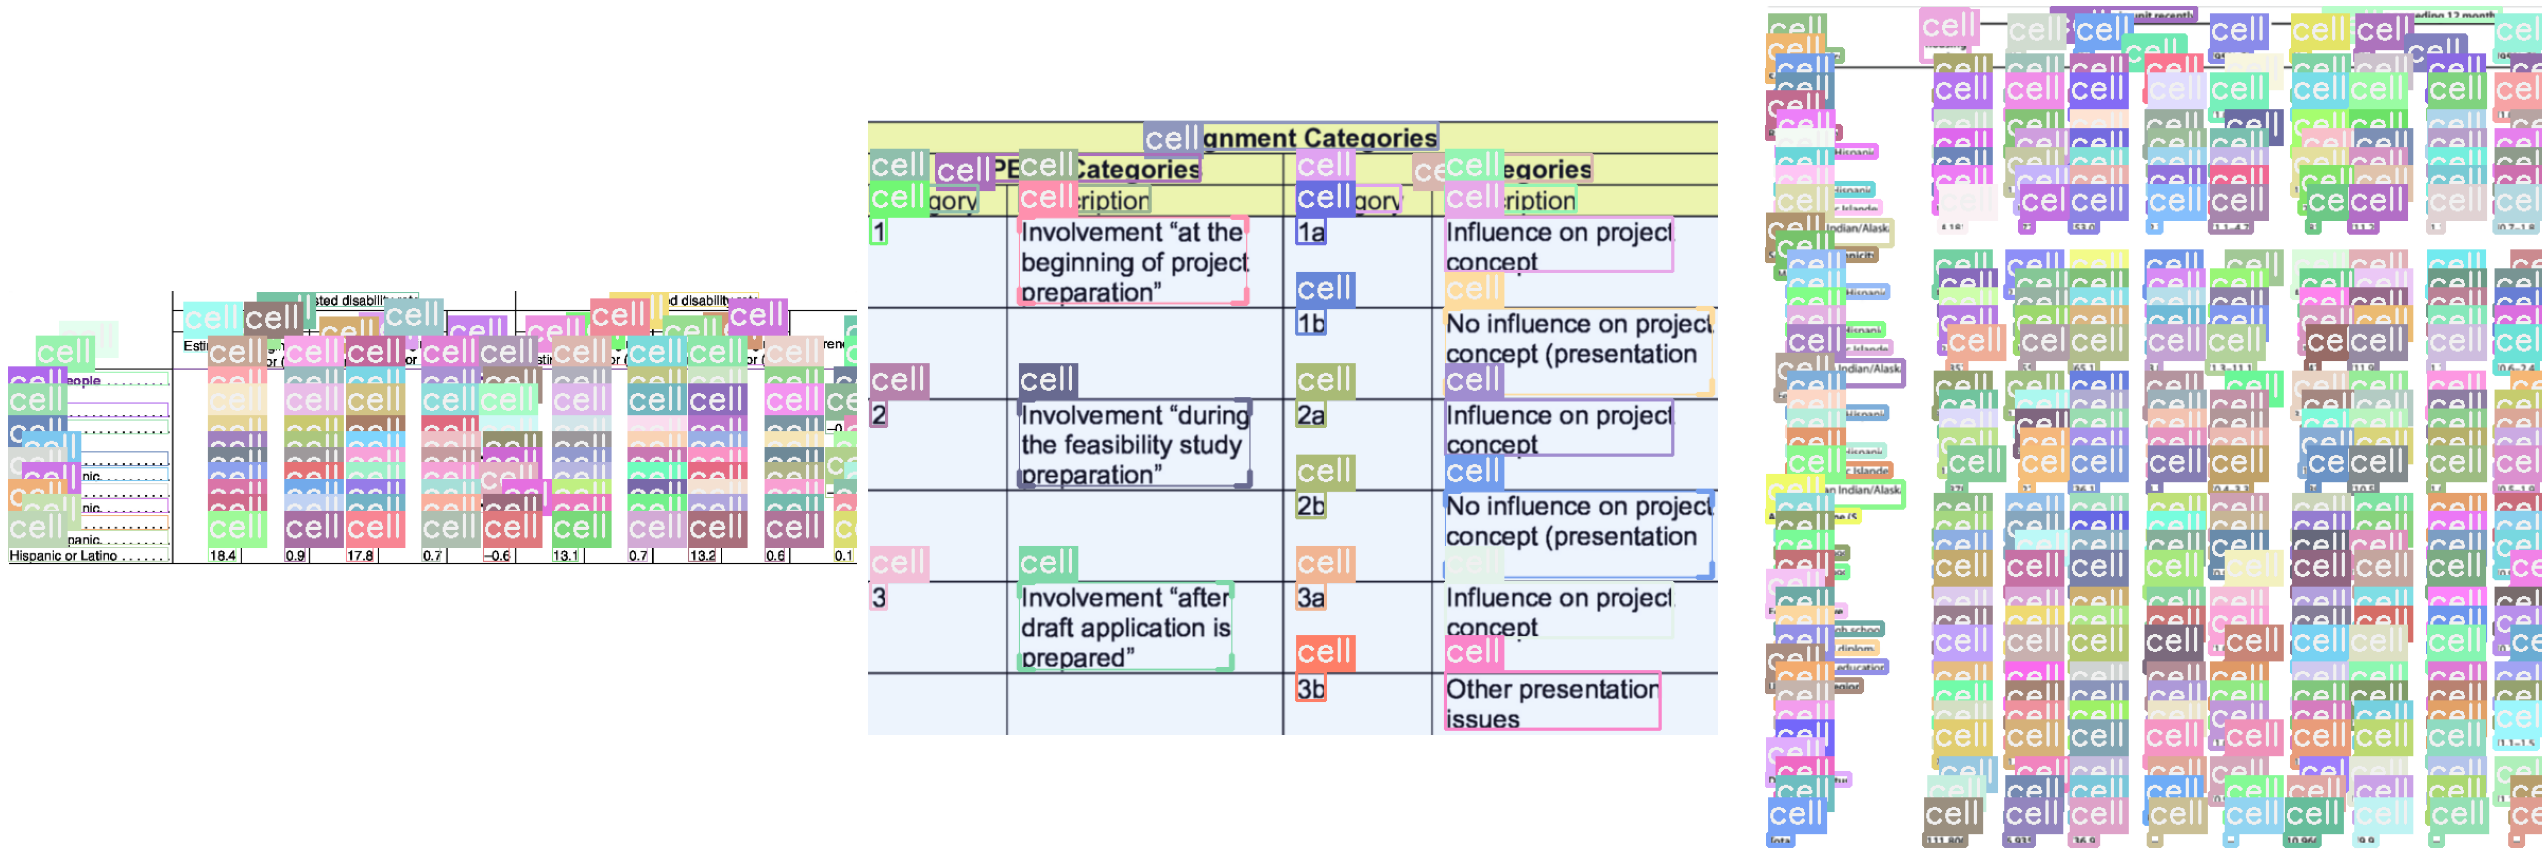

In [18]:
samples = [train_ds[i] for i in range(3)]
show_samples(samples, ncols=3, class_map=class_map,denormalize_fn=denormalize_imagenet)

### 5. DataLoaders

In [30]:
train_dl = faster_rcnn.train_dl(train_ds, batch_size=2, num_workers=0, shuffle=True)
valid_dl = faster_rcnn.valid_dl(valid_ds, batch_size=2, num_workers=0, shuffle=False)
test_dl = faster_rcnn.valid_dl(test_ds, batch_size=2, num_workers=0, shuffle=False)

### 6. The model

In order to create and train our model we need to create a `Learner` object from FastAI. 
The first thing we need to do is to build the model with the architecture that we want, in this case Faster RCNN.

In [ ]:
model = faster_rcnn.model(num_classes=len(class_map))

The next thing we need to do is to define the metrics, the callbacks and the Learner:

In [23]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [22]:
callbacks = [EarlyStoppingCallback(patience=3)]

In [ ]:
learn = faster_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics,cbs=callbacks)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 7. Training

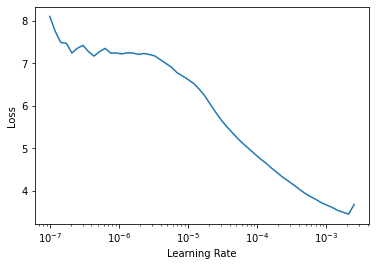

In [ ]:
(min_lr,steep)=learn.lr_find(show_plot=True)

In [ ]:
learn.fine_tune(10,steep,freeze_epochs=2)

epoch,train_loss,valid_loss,COCOMetric,time
0,7.348561,7.033381,0.015833,00:28
1,7.128666,6.808253,0.039799,00:28


epoch,train_loss,valid_loss,COCOMetric,time
0,6.174139,5.329194,0.062386,00:36
1,4.650433,2.722479,0.102119,00:36
2,2.806304,1.270810,0.149463,00:37
3,1.825078,1.041697,0.179308,00:37
4,1.373789,0.992380,0.207983,00:38
5,1.177384,0.951791,0.215081,00:39
6,1.086250,0.939808,0.227667,00:37
7,1.022606,0.924757,0.233760,00:38
8,0.998111,0.921404,0.235932,00:37
9,0.990743,0.907771,0.236842,00:39


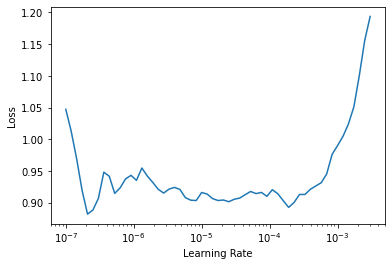

In [ ]:
(min_lr,steep)=learn.lr_find(show_plot=True)

In [ ]:
learn.fine_tune(10,steep,freeze_epochs=2)

epoch,train_loss,valid_loss,COCOMetric,time
0,0.933471,0.899613,0.246252,00:28
1,0.909523,0.887041,0.245987,00:28


epoch,train_loss,valid_loss,COCOMetric,time
0,0.925071,0.887256,0.250351,00:38
1,0.916814,0.878532,0.251619,00:37
2,0.905567,0.866139,0.255212,00:38
3,0.889726,0.854501,0.261284,00:39
4,0.874915,0.855122,0.264110,00:37
5,0.868187,0.840380,0.266602,00:38
6,0.855608,0.828768,0.265682,00:37
7,0.851027,0.838242,0.267512,00:37
8,0.847872,0.836424,0.266684,00:39
9,0.844038,0.831569,0.268184,00:37


No improvement since epoch 6: early stopping


In [ ]:
torch.save(model.state_dict(),'/content/drive/MyDrive/CellDetection/FasterRCNN_celldetection.pth')

## Evaluando el modelo

Al igual que vimos para los modelos de clasificación, la métrica mostrada durante el proceso de entrenamiento se refiere al conjunto de validación, mientras que nos interesa saber el resultado obtenido para el conjunto de test. 

Para ello, lo primero que debemos hacer es construir un nuevo dataloader del siguiente modo, indicando que el conjunto de validación es el de test. 

In [20]:
model = faster_rcnn.model(num_classes=len(class_map))
state_dict = torch.load('/content/FasterRCNN_celldetection.pth')
model.load_state_dict(state_dict)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

<All keys matched successfully>

In [31]:
learn = faster_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics,cbs=callbacks)

In [32]:
newdl = fastai.DataLoaders(faster_rcnn.fastai.convert_dataloader_to_fastai(train_dl),faster_rcnn.fastai.convert_dataloader_to_fastai(test_dl)).to('cuda')

A continuación modificamos el dataloader del objeto `Learn` que hemos entrenado anteriormente.

In [33]:
learn.dls = newdl

In [34]:
learn.validate()

(#2) [0.629314124584198,0.3739432464596845]

Por último evaluamos nuestro modelo usando el método `validate()`. Al igual que en el caso de los modelos de clasificación el método `validate()` devuelve dos valores, el valor de la pérdida y el valor de la métrica asociada al conjunto de validación, que en este caso es el de test. 

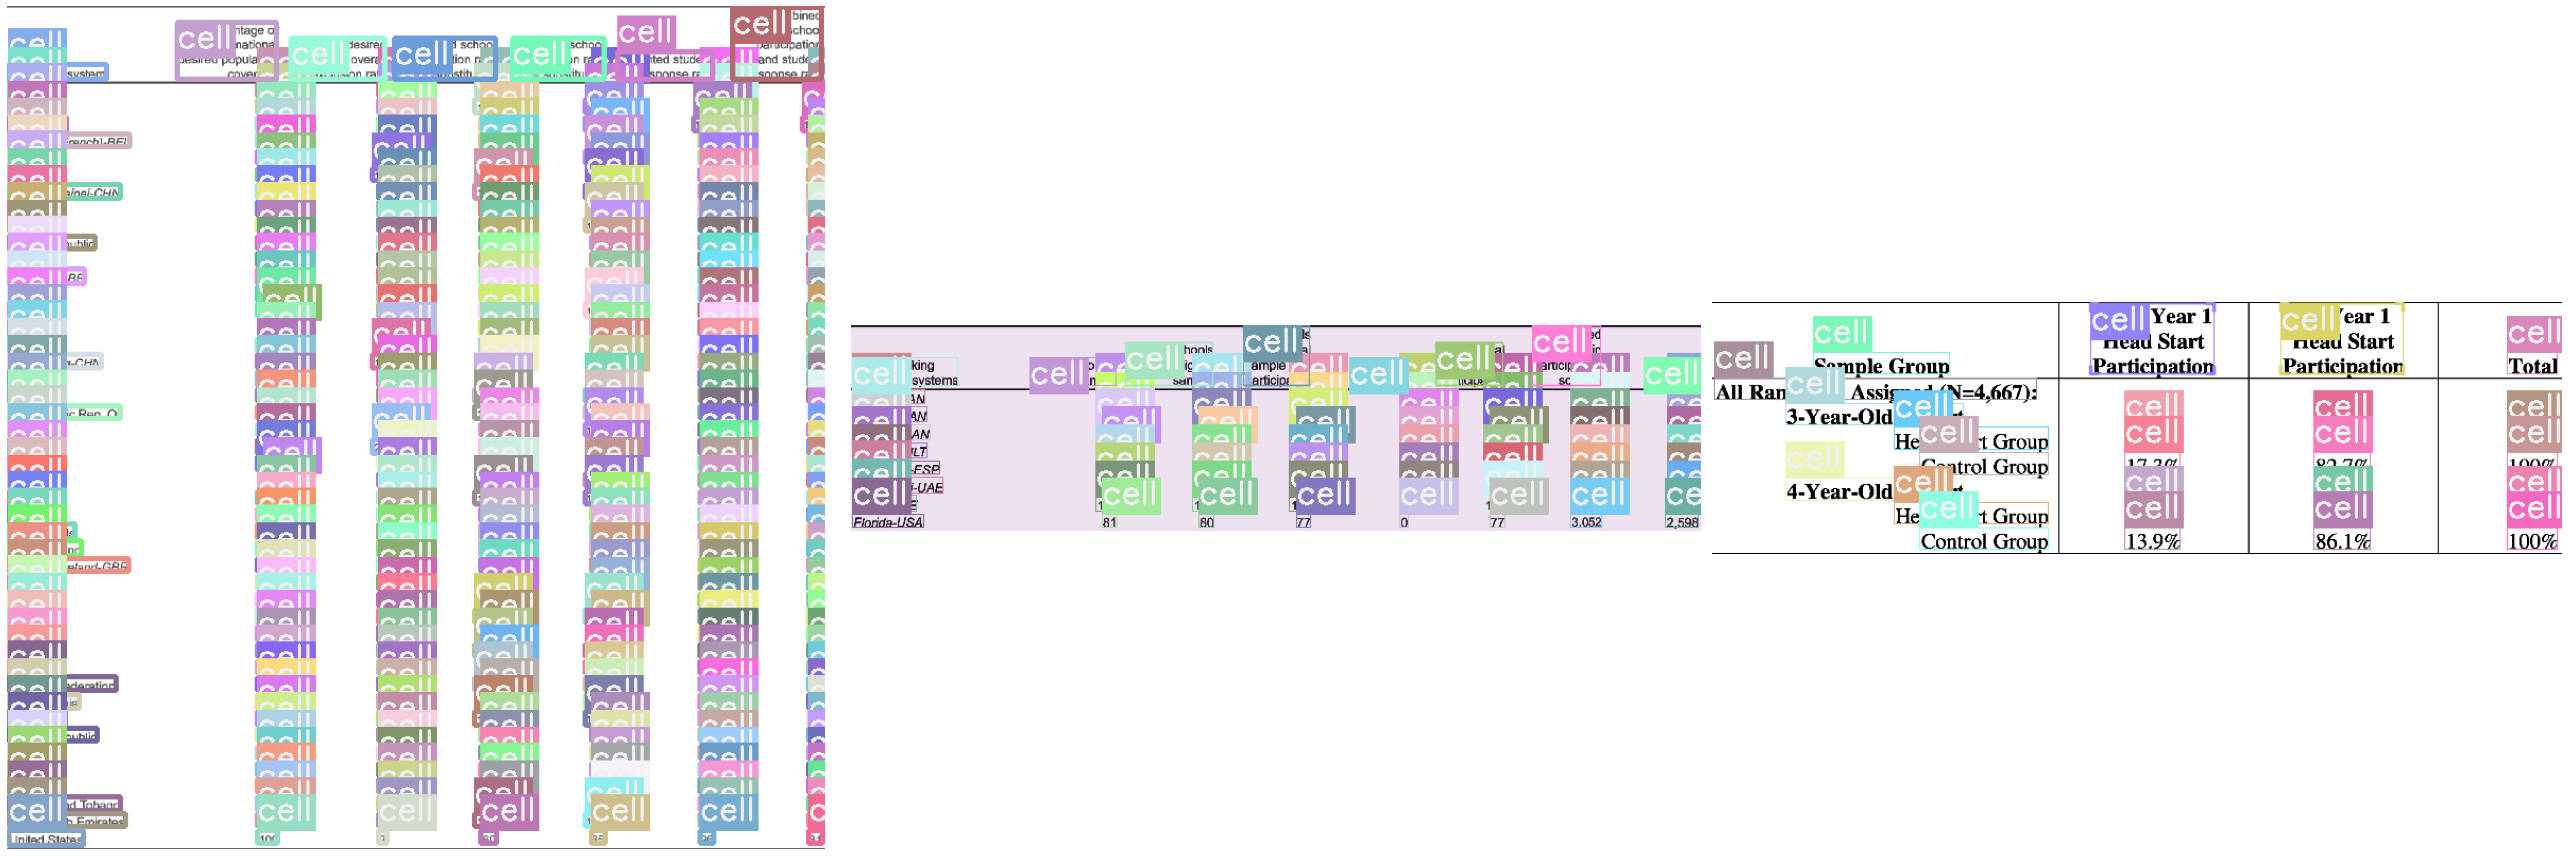

In [ ]:
samples = [newdl.dataset[i] for i in range(3)]
show_samples(samples, ncols=3, class_map=class_map,denormalize_fn=denormalize_imagenet)

## Inferencia

In [ ]:
import PIL

In [ ]:
img = np.array(PIL.Image.open('/content/celldataset/test/images/eu-001-1-3.jpg'))

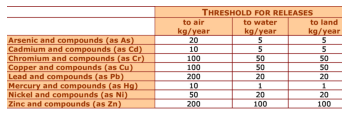

In [ ]:
show_img(img);

In [ ]:
infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size),tfms.A.Normalize()])

In [ ]:
infer_ds = Dataset.from_images([img], infer_tfms)

In [ ]:
batch, samples = faster_rcnn.build_infer_batch(infer_ds)
preds = faster_rcnn.predict(model=model, batch=batch,detection_threshold=0.5)

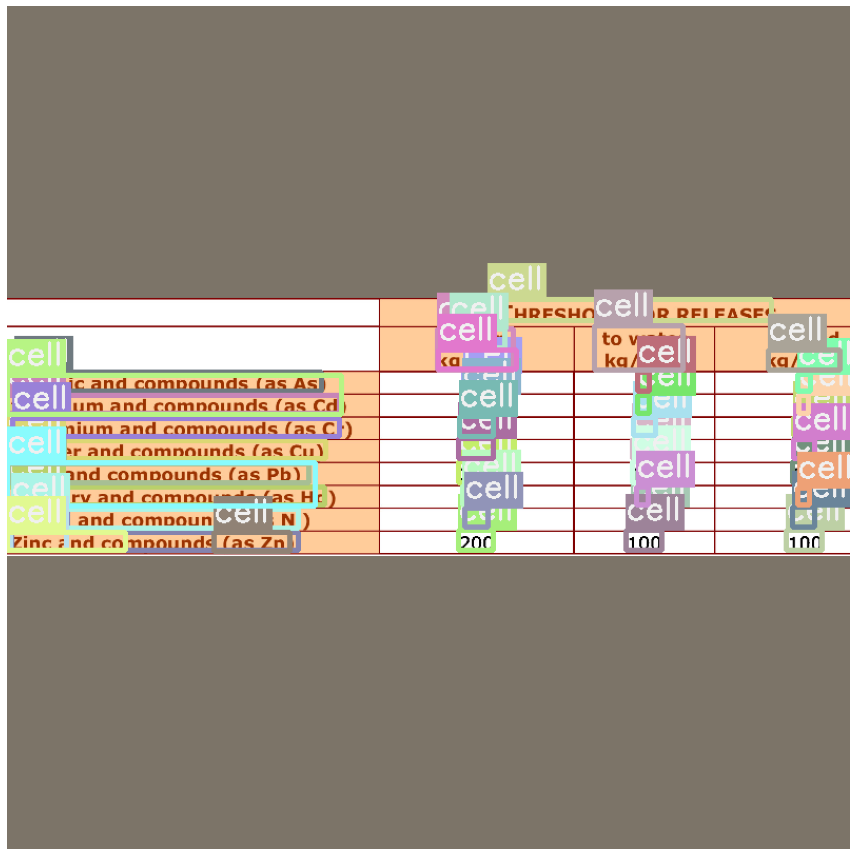

In [ ]:
imgs = [sample["img"] for sample in samples]
show_preds(
    samples=imgs,
    preds=preds,
    class_map=class_map,
    denormalize_fn=denormalize_imagenet,
    show=True,
)